In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('Uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle (3).json
Uploaded file "kaggle (3).json" with length 70 bytes


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = '/content/'

In [ ]:
!kaggle datasets download -d kshitij192/cars-image-dataset

cars-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip //content/cars-image-dataset.zip

Archive:  //content/cars-image-dataset.zip
replace Cars Dataset/test/Audi/1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 0
error:  invalid response [0]
replace Cars Dataset/test/Audi/1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace Cars Dataset/test/Audi/1003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !unzip '*.zip' && rm *.zip
# --------

Load and Preprocess the Data:


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


train_dir = '/content/Cars Dataset/train'
test_dir = '/content/Cars Dataset/test'
img_height, img_width = 224, 224
batch_size = 32

In [ ]:
len(train_dir),len(test_dir)

(27, 26)

In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
 )

In [ ]:
# Load training data and split into training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Use subset argument to specify 'training' split
)

Found 3352 images belonging to 7 classes.


In [ ]:
# No data augmentation for the test set, only rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 813 images belonging to 7 classes.


In [ ]:
class_indices = train_generator.class_indices

In [ ]:
# Initialize a dictionary to store the count of images for each class
class_counts = {class_name: 0 for class_name in class_indices}

In [ ]:
# Loop through the files in the train directory and count the images for each class
for class_name in class_indices:
    class_dir = os.path.join(train_dir, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts[class_name] = class_count

# Print the count of images for each class
for class_name, count in class_counts.items():
    print(f"Number of images in class {class_name}: {count}")

Number of images in class Audi: 814
Number of images in class Hyundai Creta: 271
Number of images in class Mahindra Scorpio: 316
Number of images in class Rolls Royce: 311
Number of images in class Swift: 424
Number of images in class Tata Safari: 441
Number of images in class Toyota Innova: 775


Calculate Class Weights:


Regarding the class imbalance problem:
Yes, there is a class imbalance problem in this dataset. The number of images varies significantly across different classes. This can lead to biases during model training, where the model might become biased towards the majority class and perform poorly on the minority classes.

In [ ]:
sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1])

# Most represented class (last element in sorted list)
most_represented_class = sorted_class_counts[-1]
most_represented_class_name, most_represented_count = most_represented_class

# Least represented class (first element in sorted list)
least_represented_class = sorted_class_counts[0]
least_represented_class_name, least_represented_count = least_represented_class

# Print the most and least represented classes
print("Most represented class:", most_represented_class_name, "with", most_represented_count, "images")
print("Least represented class:", least_represented_class_name, "with", least_represented_count, "images")

Most represented class: Audi with 814 images
Least represented class: Hyundai Creta with 271 images


In [ ]:
target_count = max(class_counts.values())
print(target_count)

814


In [ ]:
import numpy as np
from collections import Counter

oversampled_data = []
for class_name, count in class_counts.items():
    class_dir = os.path.join(train_dir, class_name)
    filenames = os.listdir(class_dir)
    if count < target_count:
        sampled_filenames = np.random.choice(filenames, target_count - count, replace=True)
        oversampled_data.extend([os.path.join(class_dir, filename) for filename in sampled_filenames])
        # Add original data
        oversampled_data.extend([os.path.join(class_dir, filename) for filename in filenames])
    else:
        oversampled_data.extend([os.path.join(class_dir, filename) for filename in filenames])


# Get the count of images for each class after oversampling
class_counts_oversampled = Counter(oversampled_data)

In [ ]:
class_counts_oversampled = Counter([os.path.dirname(filepath) for filepath in oversampled_data])
# class_counts_oversampled = Counter(oversampled_data)
# Print the count of images for each class before oversampling

print("Before oversampling:")
for class_name, count in class_counts.items():
    print(f"Number of images in class {class_name}: {count}")

# Print the count of images for each class after oversampling
print("\nAfter oversampling:")
for class_name, count in class_counts_oversampled.items():
    print(f"Number of images in class {class_name}: {count}")

Before oversampling:
Number of images in class Audi: 814
Number of images in class Hyundai Creta: 271
Number of images in class Mahindra Scorpio: 316
Number of images in class Rolls Royce: 311
Number of images in class Swift: 424
Number of images in class Tata Safari: 441
Number of images in class Toyota Innova: 775

After oversampling:
Number of images in class /content/Cars Dataset/train/Audi: 814
Number of images in class /content/Cars Dataset/train/Hyundai Creta: 814
Number of images in class /content/Cars Dataset/train/Mahindra Scorpio: 814
Number of images in class /content/Cars Dataset/train/Rolls Royce: 814
Number of images in class /content/Cars Dataset/train/Swift: 814
Number of images in class /content/Cars Dataset/train/Tata Safari: 814
Number of images in class /content/Cars Dataset/train/Toyota Innova: 814


In [ ]:
import pandas as pd

In [ ]:
# Calculate class weights before oversampling
class_weights_before = {}
total_samples_before = sum(class_counts.values())
for class_name, count in class_counts.items():
    class_weights_before[class_name] = total_samples_before / (len(class_counts) * count)

# Calculate class weights after oversampling
class_weights_after = {}
total_samples_after = sum(class_counts_oversampled.values())
for class_name, count in class_counts_oversampled.items():
    class_weights_after[class_name] = total_samples_after / (len(class_counts_oversampled) * count)

# Print class weights before oversampling
print("Class weights before oversampling:")
for class_name, weight in class_weights_before.items():
    print(f"Class {class_name}: {weight}")

# Print class weights after oversampling
print("\nClass weights after oversampling:")
for class_name, weight in class_weights_after.items():
    print(f"Class {class_name}: {weight}")

Class weights before oversampling:
Class Audi: 0.5882765882765882
Class Hyundai Creta: 1.7670005271481286
Class Mahindra Scorpio: 1.515370705244123
Class Rolls Royce: 1.5397335783187873
Class Swift: 1.1293800539083558
Class Tata Safari: 1.0858438613540655
Class Toyota Innova: 0.6178801843317973

Class weights after oversampling:
Class /content/Cars Dataset/train/Audi: 1.0
Class /content/Cars Dataset/train/Hyundai Creta: 1.0
Class /content/Cars Dataset/train/Mahindra Scorpio: 1.0
Class /content/Cars Dataset/train/Rolls Royce: 1.0
Class /content/Cars Dataset/train/Swift: 1.0
Class /content/Cars Dataset/train/Tata Safari: 1.0
Class /content/Cars Dataset/train/Toyota Innova: 1.0


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:")
for class_label, weight in class_weights_dict.items():
    print(class_label, ":", weight)

Class Weights:
0 : 0.5882765882765882
1 : 1.7670005271481286
2 : 1.515370705244123
3 : 1.5397335783187873
4 : 1.1293800539083558
5 : 1.0858438613540655
6 : 0.6178801843317973


 image processing techniques,like-Resizing,Data Augmentation, you can preprocess your input data effectively, improving the performance and robustness of your CNN classification model. Additionally, these techniques help in reducing overfitting and enhancing the model's ability to generalize to new, unseen data.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 output classes
])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 The 'adam' optimizer will be used to minimize the categorical cross-entropy loss during training, aiming to improve the model's accuracy on the multi-class classification task.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# Train the model with class weights
car_model = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,  # added to specify the number of validation steps
    epochs=100,class_weight=class_weights_dict
)

Epoch 1/100
104/104 [==============================] - 53s 435ms/step - loss: 2.0428 - accuracy: 0.1373 - val_loss: 1.9252 - val_accuracy: 0.1262
Epoch 2/100
104/104 [==============================] - 45s 432ms/step - loss: 1.9439 - accuracy: 0.0958 - val_loss: 1.9476 - val_accuracy: 0.1300
Epoch 3/100
104/104 [==============================] - 43s 412ms/step - loss: 1.9363 - accuracy: 0.1355 - val_loss: 1.9460 - val_accuracy: 0.1175
Epoch 4/100
104/104 [==============================] - 44s 420ms/step - loss: 1.9303 - accuracy: 0.1883 - val_loss: 1.9263 - val_accuracy: 0.1275
Epoch 5/100
104/104 [==============================] - 44s 424ms/step - loss: 1.9274 - accuracy: 0.1690 - val_loss: 1.8815 - val_accuracy: 0.2387
Epoch 6/100
104/104 [==============================] - 45s 429ms/step - loss: 1.8729 - accuracy: 0.2187 - val_loss: 1.8247 - val_accuracy: 0.2887
Epoch 7/100
104/104 [==============================] - 44s 421ms/step - loss: 1.8304 - accuracy: 0.2533 - val_loss: 1.8978 -

In [ ]:
model.save('/content/car_model_new.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import numpy as np

In [ ]:
y_pred = model.predict(test_generator)
y_true = test_generator.classes

In [ ]:
# Convert probabilities to class predictions
y_pred_classes = np.argmax(y_pred, axis=1)
unique_classes, class_counts = np.unique(y_pred_classes, return_counts=True)

# Print the unique class indices and their counts
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: Count {count}")

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred_classes)
# it takes the weighted average,
# where each class's contribution is proportional to the number of samples in that class.

In [ ]:
car_model.history.keys()

In [ ]:
# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
# Plot the confusion matrix (Optional)
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
acc = car_model.history['accuracy']
val_acc = car_model.history['val_accuracy']

loss = car_model.history['loss']
val_loss = car_model.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import classification_report
y_true=test_generator.classes
predictions=model.predict(test_generator,  steps =813)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(y_true,y_pred))

In [ ]:
from keras.models import load_model
from keras.preprocessing import image

# Load the saved model
saved_model_path = '/content/drive/MyDrive/car_image_dataset_CNN_model/car_model_new.h5'
loaded_model = load_model(saved_model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
img_height = 224
img_width = 224
# Load and preprocess the new image
image_path = '/content/4.jpg'
img = load_img(image_path, target_size=(img_height, img_width))  # Assuming you have set img_height and img_width appropriately
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
preprocessed_image = preprocess_input(img_array)
# Make predictions

# Make predictions
predictions = loaded_model.predict(preprocessed_image)
print(predictions)

print("Prediction percentages:", prediction_percentages)
# Convert predictions to class labels (assuming one-hot encoded predictions)
predicted_class_index = np.argmax(predictions[0])
print(predicted_class_index)

1/1 [==============================] - 0s 83ms/step
[[5.5264470e-15 1.6747593e-25 2.9329042e-29 8.7100124e-25 1.0000000e+00
  2.7515616e-08 3.0986994e-13]]
Prediction percentages: [11.471148 11.471148 11.471148 11.471148 31.168053 11.476212 11.471148]
4


In [ ]:
# Class mapping
class_mapping = {
    0: 'class_A',
    1: 'class_B',
    2: 'class_C',
    3: 'class_D',
    4: 'class_E',
    # Add more class mappings as needed
}

# Get predicted class name using class_mapping
predicted_class_name = class_mapping[predicted_class_index]
print("Predicted Class:", predicted_class_name)

Predicted Class: class_E


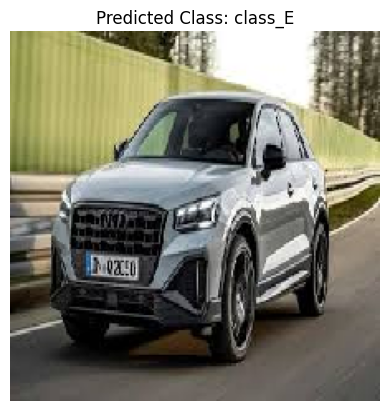

In [ ]:
import matplotlib.pyplot as plt
# Get predicted class name using class_mapping
predicted_class_name = class_mapping.get(predicted_class_index, 'Unknown')

# Display the image
plt.imshow(img)
plt.title('Predicted Class: ' + predicted_class_name)
plt.axis('off')  # Remove axis ticks and labels
plt.show()